In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/MyDrive/Semantic_segmentation_dataset"

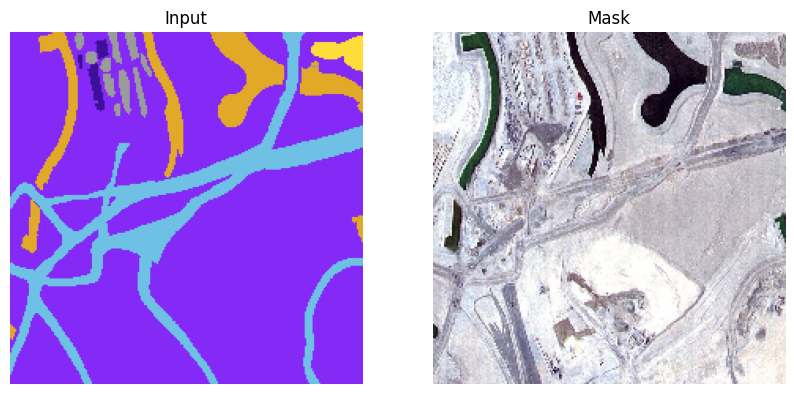

In [3]:
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to load images and masks
def loadImg(path, dirTile):
    input_img, mask_img = [], []
    path = os.path.join(path, dirTile)
    inpDir, maskDir = os.listdir(path)

    imgDirs = sorted(os.listdir(os.path.join(path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(path, maskDir)))

    for imgDir in imgDirs:
        imgDir = os.path.join(path, inpDir, imgDir)
        img = load_img(imgDir, target_size=(224, 224))
        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        input_img.append(img)

    for mask_imgDir in mask_imgDirs:
        mask_imgDir = os.path.join(path, maskDir, mask_imgDir)
        mask = load_img(mask_imgDir, target_size=(224, 224))
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0
        mask_img.append(mask)

    return input_img, mask_img

# Function to load the entire dataset
def loadData(path, listDir):
    imgs_data, masks_data = [], []
    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(path, dirTile)
        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data

# List directories in the dataset
listDir = []
for dir in os.listdir(path):
    if dir != "classes.json":
        listDir.append(dir)
listDir = sorted(listDir)

# Load the dataset
input_imgs, mask_imgs = loadData(path, listDir)

# Visualize a sample image and mask
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[0])
plt.axis("off")
plt.show()

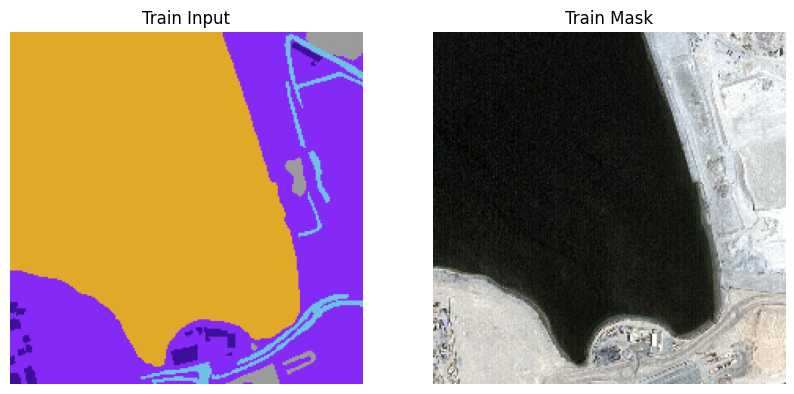

In [4]:
# Split the dataset
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    input_imgs, mask_imgs, test_size=0.2, shuffle=True, random_state=42
)

# Visualize a sample from the training set
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Train Input")
plt.imshow(train_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Train Mask")
plt.imshow(train_masks[0])
plt.axis("off")
plt.show()

In [5]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D, Concatenate, Multiply, Add, Activation
from keras.models import Model

# Define the attention gate
def attention_gate(inputs, gating_signal, inter_channels):
    gating_conv = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(gating_signal)
    gating_conv = BatchNormalization()(gating_conv)
    gating_conv = Activation('relu')(gating_conv)

    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(inputs)
    theta_x = BatchNormalization()(theta_x)
    theta_x = Activation('relu')(theta_x)

    add = Add()([gating_conv, theta_x])
    add = Activation('relu')(add)

    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(add)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)

    attention = Multiply()([inputs, psi])
    return attention

# Define encoder block
def Conv(x, dropout, filters):
    conv = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    conv = Dropout(dropout)(conv)
    conv = BatchNormalization()(conv)

    conv = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv)
    conv = Dropout(dropout)(conv)
    conv = BatchNormalization()(conv)

    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

# Define decoder block
def UpSample(x, skip, dropout, filters):
    up = UpSampling2D(size=(2, 2))(x)
    up = Conv2D(filters, kernel_size=2, padding='same', activation='relu')(up)
    up = Concatenate()([up, skip])

    up = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(up)
    up = Dropout(dropout)(up)
    up = BatchNormalization()(up)

    up = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(up)
    up = Dropout(dropout)(up)
    up = BatchNormalization()(up)

    return up

# Define the U-Net model with attention
def UNet(x, dropout, conv=[32, 64, 128, 256, 512]):
    # Encoder
    conv1, pool1 = Conv(x, dropout, conv[0])  # 224 -> 112
    conv2, pool2 = Conv(pool1, dropout, conv[1])  # 112 -> 56
    conv3, pool3 = Conv(pool2, dropout, conv[2])  # 56 -> 28
    conv4, pool4 = Conv(pool3, dropout, conv[3])  # 28 -> 14

    # Bottleneck
    conv5 = Conv2D(filters=conv[4], kernel_size=3, padding='same', activation='relu')(pool4)
    conv5 = Dropout(dropout)(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder with attention gates
 # Use UpSampling2D to match the shapes before applying attention gate
    up_conv5 = UpSampling2D(size=(2, 2))(conv5)
    attn4 = attention_gate(conv4, up_conv5, conv[4]) # Now, conv4 and up_conv5 have compatible shapes
    conv6 = UpSample(conv5, attn4, dropout, conv[4])  # 14 -> 28

    # Similar shape adjustments for other attention gates
    up_conv6 = UpSampling2D(size=(2, 2))(conv6)
    attn3 = attention_gate(conv3, up_conv6, conv[3])
    conv7 = UpSample(conv6, attn3, dropout, conv[3])  # 28 -> 56

    up_conv7 = UpSampling2D(size=(2, 2))(conv7)
    attn2 = attention_gate(conv2, up_conv7, conv[2])
    conv8 = UpSample(conv7, attn2, dropout, conv[2])  # 56 -> 112

    up_conv8 = UpSampling2D(size=(2, 2))(conv8)
    attn1 = attention_gate(conv1, up_conv8, conv[1])
    conv9 = UpSample(conv8, attn1, dropout, conv[1])  # 112 -> 224

    # Output
    result = Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')(conv9)
    return result

# Build the model
input = Input(shape=(224, 224, 3))
output = UNet(input, dropout=0.1)
model = Model(inputs=input, outputs=output)
model.summary()

# Compile the model
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 224, 224, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 112, 112, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ dropout_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 112, 112, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ dropout_3[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)  

 Total params: 12,558,199 (47.91 MB)

 Trainable params: 12,547,567 (47.87 MB)

 Non-trainable params: 10,632 (41.53 KB)

In [6]:
history = model.fit(
    np.array(train_imgs), np.array(train_masks),
    batch_size=8,
    epochs=10,
    validation_data=(np.array(test_imgs), np.array(test_masks))
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 182s 12s/step - accuracy: 0.3673 - loss: 0.7654 - val_accuracy: 0.2352 - val_loss: 0.8734
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 411ms/step - accuracy: 0.4540 - loss: 0.6343 - val_accuracy: 0.1744 - val_loss: 4.9689
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step - accuracy: 0.4774 - loss: 0.6185 - val_accuracy: 0.5978 - val_loss: 14.2843
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - accuracy: 0.4724 - loss: 0.5971 - val_accuracy: 0.5749 - val_loss: 2.8291
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.5284 - loss: 0.5909 - val_accuracy: 0.4597 - val_loss: 0.7476
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.4646 - loss: 0.5880 - val_accuracy: 0.5984 - val_loss: 0.7317
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.4937 - loss: 0.5765 - val_accuracy: 0.5757 - val_loss: 0.6918
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.5135 - loss: 0.5936 - val_accuracy: 0.5765 - val_los

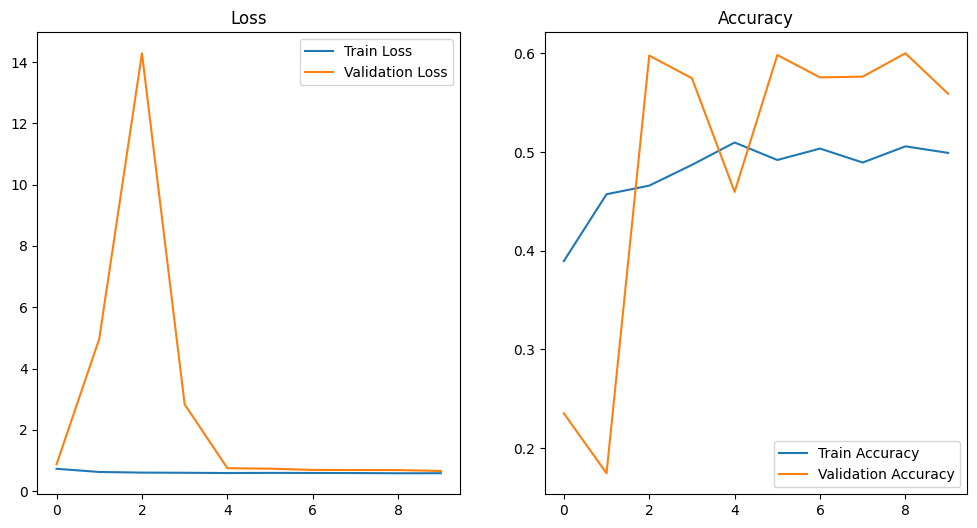

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


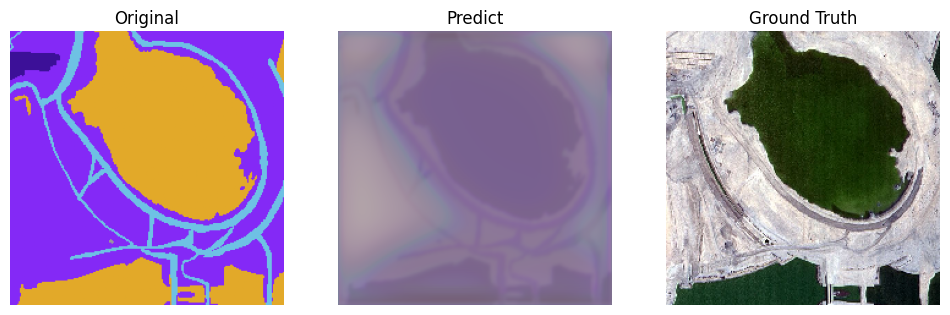

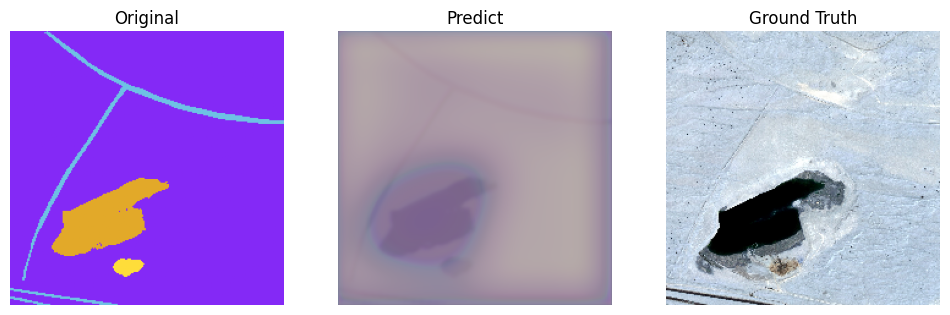

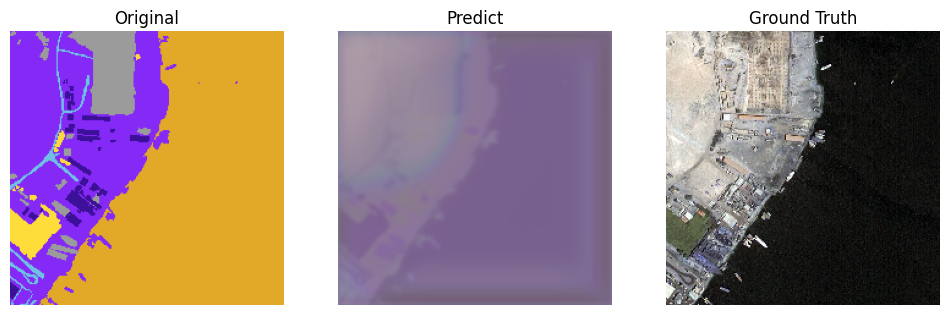

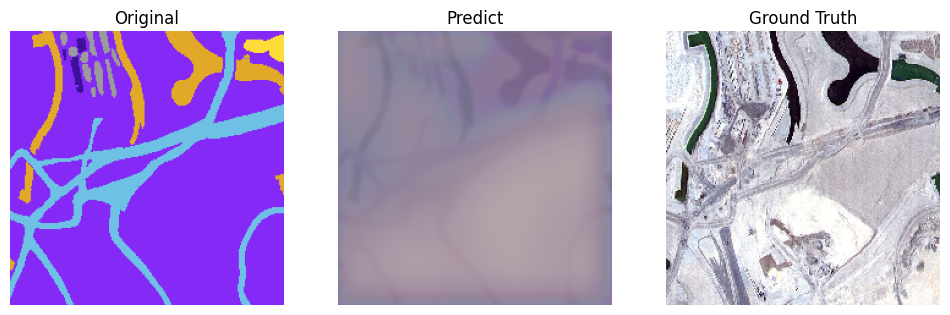

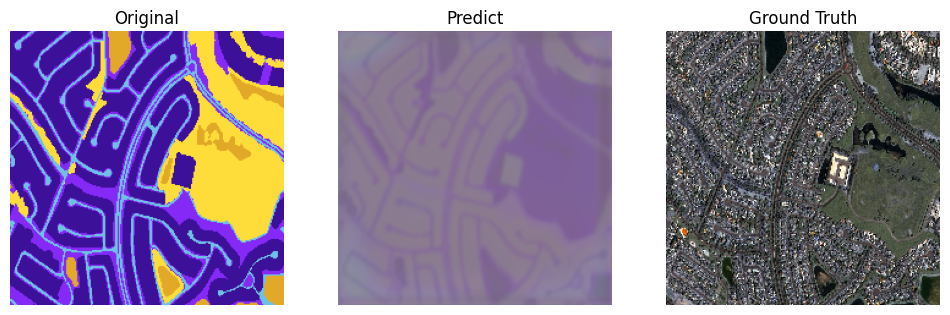

In [7]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Visualize predictions
images_predict = model.predict(np.array(test_imgs))

def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize=(12, 7))
    ax[0].set_title('Original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('Predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title('Ground Truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

for id in range(5):
    show_result(id)